# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели, введение в конкурсную задачу


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 апреля 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 апреля, -4 балла после 06:00 24 апреля, -6 баллов после 06:00 1 мая

Имеется ввиду именно сдача данного ДЗ, а не конечного результата по конкурсу (см ниже).<br\>
Жесткий дедлайн по конкурсной задаче - 14 мая 23:59 GMT.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [9]:
USER_NAME = u"Крылов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", " Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода%s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

$$
g(x,w) = w_0 + \sum_{j=1}^d w_j x_j; \, h(x,w) = \sigma(g(x,w))
$$

$$
L_{Lasso}(w) = -\frac{1}{n} \sum_{i=1}^n \log(\sigma(y_i*g(x_i,w))) + \frac{1}{C} \sum_{j=0}^d | w_j |
$$
$$
\frac{\partial L}{\partial w_0} = \frac{w_0}{|w_0|C}−\frac{1}{n}\sum_{i=1}^n\frac{y_i e^{−g(x_i,w)y_i}}{e^{−g(x_i,w)y_i}+1}
$$
$$
\frac{\partial L}{\partial w_j} = \frac{w_j}{|w_j|C}−\frac{1}{n}\sum_{i=1}^n\frac{x_{ij} y_i e^{−g(x_i,w)y_i}}{e^{−g(x_i,w)y_i}+1} \, \forall j = 1 \dots d
$$

# Реализация модели

## Имплементация (6 баллов)

In [143]:
from sklearn.base import BaseEstimator, ClassifierMixin

def _sigma(z): # just sigmoid
    return 1/(1+np.exp(-z))

def _g(x,w): # distance to hyperplane
    return w[0] + w[1:].T.dot(x)

def _h(x,w): # probability
    return _sigma(_g(x,w))

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def _L_grad(self,X,y):
        grad = np.empty(X.shape[1]+1)
        grad[0] = np.sign(self.weights[0])/self.C - 1/X.shape[0] * np.sum([
            y[i] * np.exp(-_g(X[i],self.weights) * y[i])
            / (
                1 + np.exp(-_g(X[i],self.weights) * y[i])
            )
            for i in xrange(X.shape[0])
        ])
        for j in xrange(X.shape[1]):
            grad[j+1] = np.sign(self.weights[j+1])/self.C - 1/X.shape[0] * np.sum([
                X[i,j] * y[i] * np.exp(-_g(X[i],self.weights) * y[i])
                / (
                    1 + np.exp(-_g(X[i],self.weights) * y[i])
                )
                for i in xrange(X.shape[0])
            ])
        return grad
    
    def _L(self,X,y): # loss
        return -1/X.shape[0] * np.sum(
            [np.log(_sigma(y*_g(x,self.weights))) for x in X]
        ) + 1/self.C * np.sum(np.abs(self.weights)) # L1
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        self.weights = np.random.rand(X.shape[1]+1) # OMFG
        print "loss", 0, self._L(X,y)
        return self.partial_fit(X, y)
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        indices = range(X.shape[0])
        for epoch in xrange(self.max_epoch):
            np.random.shuffle(indices)
            for i in indices:
                self.weights -= self.alpha/(epoch+1) * self._L_grad(X,y)
            print "loss", epoch+1, self._L(X,y)
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        return np.sign([_g(x,self.weights) for x in X])
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        return [_h(x,self.weights) for x in X]

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

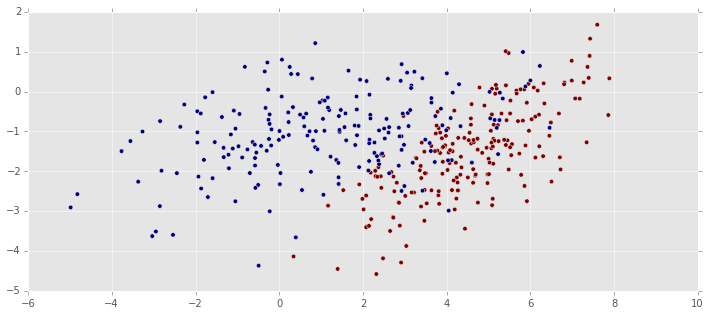

In [144]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
#y = np.r_[np.ones(200), np.zeros(200)]
y = np.r_[np.ones(200), -np.ones(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [149]:
np.random.seed(42)
model = MySGDClassifier(alpha=.002,max_epoch=10,C=2.)
model.fit(X, y)

loss 0 254021.319016
loss 1 168075.705018
loss 2 138704.256649
loss 3 124028.796215
loss 4 114867.678672
loss 5 111310.139122
loss 6 110903.550879
loss 7 110903.550879
loss 8 110903.549287
loss 9 110903.549287
loss 10 110903.550338


MySGDClassifier(C=2.0, alpha=0.002, max_epoch=10)

[  9.01188474e-05   4.76397432e-05  -6.05818860e-06]


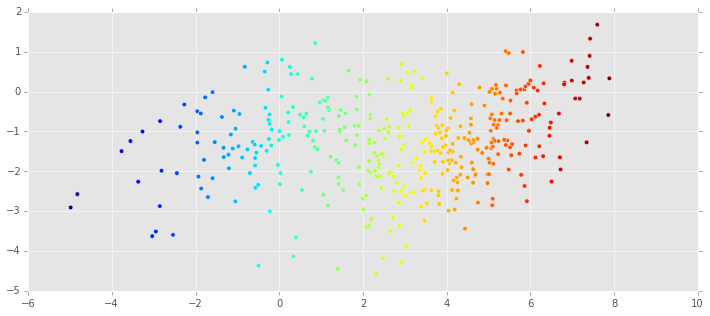

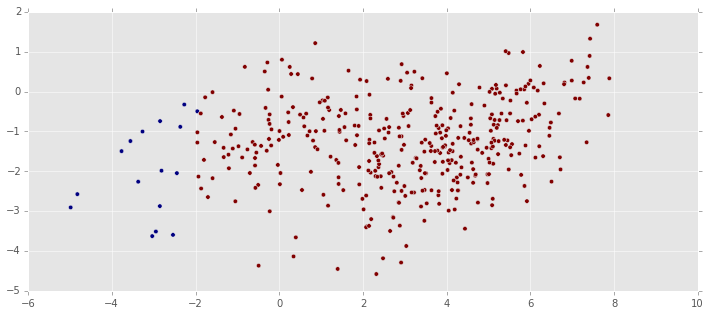

In [150]:
plt.scatter(X[:,0],X[:,1],c=model.predict_proba(X))
plt.figure()
plt.scatter(X[:,0],X[:,1],c=model.predict(X))
print model.weights

## Анализ сходимости (2 балл)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

In [ ]:
## Your Code Here

# Введение в конкурсную задачу

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

### Правила
* Объединяться в команды по правилам конкурса можно, но по правилам нашего курса - нельзя)
* Вы можете использовать любой алгоритм, даже неизученный в нашем курсе (если на защите сможете объяснить как он работает)
* Имейте ввиду, что вы должны отправить результаты строго до 14 мая 23:59 GMT на сайт соревнования (раздел submission). Без результата в leaderboard оценка выставлена не будет.

## Данные

Для того, чтобы получить данные необходимо зарегистрироваться на сайте соревнования. 

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


Данные поставляются в двух форматах:
* В формате json содержится полная информация по текущему состоянию раунда
* В табличном формате упрощенная аггрерированная информация по текущему состоянию раунда

В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если данные не будут помещаться вам с оперативную память, рекомендуется совершить предобработку в python, а  моделирование выполнять с помощью [vowpal wabbit](https://github.com/JohnLangford/vowpal_wabbit).

In [4]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))

# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv.gz'
df_data = pd.read_csv(filepath, sep=',')

In [5]:
df_data.shape

(500000, 45)

In [6]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [7]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [8]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.50470199999999998

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы

In [ ]:
## Youd Code Here

## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Обучите модуль из первой части этого ДЗ на данных

In [ ]:
y = df_data.decision.values

## Применение модели (3 балла)
#### Задание
* Загрузите тестовые данные
* Выполните те же операции с датасетом, что и с обучающей выборкой
* Примените модель и загрузите решение на страницу конкурса
* Напечатайте ваш ник и оценку качества, полученную после загрузки

Судя по описанию, submission file должен состоять из одного столбца с числами, соответствующим вероятностям победы игрока.

In [ ]:
## Youd Code Here